In [1]:
import pandas as pd
import re
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import torch
import torch.utils.data as data_utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [2]:
torch.cuda.is_available()

True

In [3]:
train=pd.read_csv("/content/IMDBDataset.csv",error_bad_lines=False,engine="python")
train.head(100)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 5506: unexpected end of data


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
95,Daniel Day-Lewis is the most versatile actor a...,positive
96,My guess would be this was originally going to...,negative
97,"Well, I like to watch bad horror B-Movies, cau...",negative
98,"This IS the worst movie I have ever seen, as w...",negative


### EDA

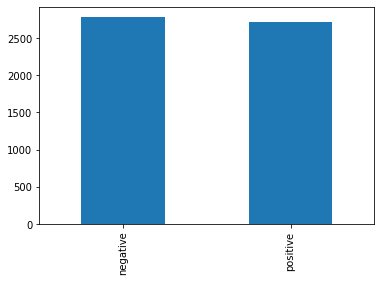

In [4]:
#distribution of sentiments
train["sentiment"].value_counts().plot(kind='bar')

#distribution of text length 

In [5]:
train['len_r']=train['review'].apply(lambda x: len(x.split()))
train['len_r'].agg(['mean','max','min'])


mean     232.704215
max     1737.000000
min       14.000000
Name: len_r, dtype: float64

In [6]:
#check for null values and duplicates
train.isna().sum()

review       0
sentiment    0
len_r        0
dtype: int64

## TEXT PREPEROCESSING

In [7]:
def clean(text):
    #remove links
    text = re.sub('http://\S+|https://\S+',' ', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    #remove html tags
    clean = re.compile('<[^>]*>')
    text = re.sub(clean,' ', text)
    #remove numbers
    #remove punctuations
    #remove non letters
    text = re.sub('[^a-zA-z\s]',' ',text)
    #convert to lower case and split
    text = text.lower()
    return text

In [8]:
from textblob import TextBlob
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text.split() if word not in (stop_words)]

def lemm(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text] 

def stemer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]
    
def correct(text):
   textblob = [TextBlob(word).correct().string for word in text]
   return textblob   

In [9]:
#correct("interestin moviie")

In [10]:
def preprocess_text(text):
    text=clean(text)
    #remove stop words
    text=remove_stopwords(text)
    #text=correct(text)
    text=lemm(text)
    #text= stemer(text)
    return ' '.join(text)
   
   


In [11]:
train['review']=train['review'].apply(lambda x: preprocess_text(x))
train.head()


,review,sentiment,len_r
0,one reviewer mentioned watching oz episode hoo...,positive,307
1,wonderful little production filming technique ...,positive,162
2,thought wonderful way spend time hot summer we...,positive,166
3,basically family little boy jake think zombie ...,negative,138
4,petter mattei love time money visually stunnin...,positive,230


In [12]:

reviews=train['review'].values
reviews[6]

'sure would like see resurrection dated seahunt series tech today would bring back kid excitement grew black white tv seahunt gunsmoke hero every week vote comeback new sea hunt need change pace tv would work world water adventure oh way thank outlet like view many viewpoint tv many movie ole way believe got wanna say would nice read plus point sea hunt rhyme would line would let submit leave doubt quit must go let'

## Prepare dataset

In [13]:
from nltk.tokenize import word_tokenize, sent_tokenize
def build_vocab(data):
    reviews=data['review'].values
    text=' '.join(reviews)
    text=word_tokenize(text)
    #build vocab
    counter = Counter(text)
    vocab = sorted(counter, key=counter.get, reverse=True)
    #vocab to int
    vocab_int=dict()
    vocab_int['<padding>']=0
    vocab_int={word:i+1 for i,word in enumerate(vocab)}
    return vocab_int

In [14]:
import json
vocab= build_vocab(train)
with open("sample.json", "w") as outfile:
    json.dump(vocab, outfile)

In [15]:
def encode_review(text,vocab=vocab):
  
    encoded_review=[vocab[word] for word in word_tokenize(text) if word in vocab]
       
    return encoded_review

def encode_labels(data):
    labels = data['sentiment'].values
    encoder = preprocessing.LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels 



In [16]:
#padding and truncate reviews
#on the left
def padding(reviews,seq_len):
    features=np.zeros((len(reviews),seq_len),dtype=int)
    for i,row in enumerate(reviews):
        features[i,-len(row):]=np.array(row)[:seq_len]
    return features      
    

In [17]:
def print_val(reviews,leng):
    for i in range(5):
        print(reviews[i][:leng])

In [18]:
def prepare(data):
    train['review']=train['review'].apply(lambda x: encode_review(x))
    rev=train['review'].values.tolist()
   
    labels=encode_labels(data)
    rev=padding(rev,128)
    print_val(rev,100)
    return rev,labels,len(vocab)

In [19]:
rev,labels,vocab_size=prepare(train)
vocab_size

[    3   979   802    62  2166   180  2362   103   532   522    19    27
  2915  2166  6725 16610    16   453   111   103   214    28  1640    25
  8440  1814 11742    25   747  1960  1559   470   301   453  3131   220
   239   214   325  2166 10294   243  7737  4309  2528   651 21689   837
  1072 10295   385  5369  2273  1106  1870  2017   826   224 16611 13652
   184  4893  2479   385   215    40 10296  3630 11743  4894  1373   877
  1989 13653   227  3313  5370  1560 10297  7738    34   134   141     5
    44   183  1147    25   527    93    28    25     5  2480   684    84
   242  4154  2578   137]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   267    36   211  1207  1502 16612    67
     6  1731  1198    65 10298   435 13654   201  1898   333   196    35
   398    15  2091   369 

35954

In [20]:
#load data
def load_data(reviews,labels,batch_size):
    #train_target = torch.tensor(labels.astype(np.float32))
    #train = torch.tensor(reviews.astype(np.float32)) 
    train_tensor = data_utils.TensorDataset(torch.from_numpy(reviews), torch.from_numpy(labels)) 
    train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True, drop_last=True)
    return train_loader

In [21]:
def split_data(reviews,labels):
    X_train, X_rem, y_train, y_rem = train_test_split(rev,labels, train_size=0.8)
    test_size = 0.5
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


In [22]:
X_train, X_valid, X_test, y_train, y_valid, y_test=split_data(reviews,labels)

In [23]:
batch_size=128
train_loader=load_data(X_train,y_train,batch_size)
valid_loader=load_data( X_valid,y_valid,batch_size)
test_loader=load_data(X_test,y_test,32)

In [24]:
dataiter=iter(train_loader)
x,y=dataiter.next()
print(x.size())
print(x)
print("="*80)
print(y.size())
print(y)

torch.Size([128, 128])
tensor([[   0,    0,    0,  ..., 6989,  699, 3135],
        [   0,    0,    0,  ...,  344, 2067, 2067],
        [   0,    0,    0,  ..., 7965, 2314,  251],
        ...,
        [   0,    0,    0,  ...,   52,  115, 5766],
        [   0,    0,    0,  ..., 1031, 2167,    3],
        [   0,    0,    0,  ...,   62,  318,   18]])
torch.Size([128])
tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0])


## BUILD MODEL

In [25]:
#build model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self,x,hidden):
        batch_size = x.size(0)
        x = x.long()
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        train_on_gpu=torch.cuda.is_available()
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden


## TRAIN MODEL

In [26]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
def train(epochs,model,optimizer,criterion,batch_size=batch_size,device=device):
  clip=5 # gradient clipping
  val_loss=float('inf')
    # move model to GPU, if available
  model.to(device)
  model.train()

  for e in range(epochs):
    # initialize hidden state
    hidden_states = model.init_hidden(batch_size)
    train_losses=0
    valid_losses=0
    val_acc=0
    

    for id,(reviews, labels) in enumerate(train_loader):

      reviews, labels = reviews.to(device), labels.to(device)

      hidden_states = tuple([each.data for each in hidden_states])

      # clear grads 
      model.zero_grad()

      # forwardpass
      output, hidden_states = model(reviews, hidden_states)
      
      #loss
      loss = criterion(output.squeeze(), labels.float())
      train_losses+=loss.item()
      #backpropagte
      loss.backward()

      #clip grad
      nn.utils.clip_grad_norm_(model.parameters(), clip)

      #update 
      optimizer.step()
      
      # free some memory
      del reviews, labels


    avg_train_loss= train_losses/len(train_loader)


    #validation phase

    model.eval()
    hidden_states_v = model.init_hidden(batch_size)
    
    for id,(reviews, labels) in enumerate(valid_loader):

        
        hidden_states_v = tuple([each.data for each in hidden_states_v])
        
        reviews, labels = reviews.to(device), labels.to(device)
        #forwardpass
        output, hidden_states_v  = model(reviews, hidden_states_v )
        #loss
        loss_v = criterion(output.squeeze(), labels.float())
        valid_losses += loss_v.item()

        #calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in output > 0.5], device=device)
        equals = predicted == labels
        acc = torch.mean(equals.type(torch.FloatTensor))
        val_acc+=acc.item()
        
        # free some memory
        del reviews, labels,predicted

        #back to train mode
        model.train()
        
    avg_valid_loss = valid_losses/len(valid_loader)
    avg_valid_acc = val_acc/len(valid_loader)

    if val_loss >= avg_valid_loss:
      val_loss=avg_valid_loss
     # Saving the model
    save_path = './model.pth'
    torch.save(model, save_path)
     
    print('model saved at valid loss: ',avg_valid_loss)
    print('model saved at acc: ',avg_valid_acc)
     
    print("Epoch: {}/{}...".format(e+1, epochs),
                "Loss: {:.6f}...".format(avg_train_loss),
                "Val Loss: {:.6f}".format(avg_valid_loss),
                "Val accuracy: {:.6f}".format(avg_valid_acc)) 
    print(" ")
    print("="*100)
    print(" ")



In [28]:
def test(model,batch_size,criterion,device=device):
  test_losses=0
  test_acc=0
  
  model.eval()
  for id,(reviews, labels) in enumerate(test_loader):

        hidden_states_t = model.init_hidden(batch_size)
        
        hidden_states_t = tuple([each.data for each in  hidden_states_t])
        
        reviews, labels = reviews.to(device), labels.to(device)
        #forwardpass
        output,  hidden_states_t  = model(reviews, hidden_states_t )
        #loss
        loss_t = criterion(output.squeeze(), labels.float())
        test_losses += loss_t.item()

        #calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in output > 0.5], device=device)
        equals = predicted == labels
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc+=acc.item()

  avg_test_loss= test_losses/len(test_loader)
  avg_test_acc= test_acc/len(test_loader)
  print("test Loss: {:.6f}".format(avg_test_loss),
                "test accuracy: {:.6f}".format(avg_test_acc)) 
  print(" ")
  print("="*100)
  print(" ")


In [29]:
def load_model(path):
  model = torch.load(path)
  return model

In [30]:
vocab_size = vocab_size 
output_size = 1
embedding_dim =512
hidden_dim =128
n_layers =2
dropout=0.5
model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(model)

SentimentRNN(
  (embedding): Embedding(35954, 512)
  (lstm): LSTM(512, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [31]:
#loss and optimization functions
lr=0.0005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
#train
epochs=10
train(epochs,model,optimizer,criterion)

model saved at valid loss:  0.684916689991951
model saved at acc:  0.546875
Epoch: 1/10... Loss: 0.688903... Val Loss: 0.684917 Val accuracy: 0.546875
 
 
model saved at valid loss:  0.5329562276601791
model saved at acc:  0.7421875
Epoch: 2/10... Loss: 0.611685... Val Loss: 0.532956 Val accuracy: 0.742188
 
 
model saved at valid loss:  0.4520696997642517
model saved at acc:  0.794921875
Epoch: 3/10... Loss: 0.441884... Val Loss: 0.452070 Val accuracy: 0.794922
 
 
model saved at valid loss:  0.5101861283183098
model saved at acc:  0.7890625
Epoch: 4/10... Loss: 0.294503... Val Loss: 0.510186 Val accuracy: 0.789062
 
 
model saved at valid loss:  0.5084274560213089
model saved at acc:  0.80859375
Epoch: 5/10... Loss: 0.168606... Val Loss: 0.508427 Val accuracy: 0.808594
 
 
model saved at valid loss:  0.5982981100678444
model saved at acc:  0.81640625
Epoch: 6/10... Loss: 0.085102... Val Loss: 0.598298 Val accuracy: 0.816406
 
 
model saved at valid loss:  0.7111676782369614
model sav

In [33]:
#inference
test(model,32,criterion)

test Loss: 0.852544 test accuracy: 0.790441
 
 


In [34]:
model=load_model('/content/model.pth') 
print(model)

SentimentRNN(
  (embedding): Embedding(35954, 512)
  (lstm): LSTM(512, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [42]:
def process_text(text):
  text=clean(text)
  #remove stop words
  text=remove_stopwords(text)
  text=stemer(text)
  text=' '.join(text)

  #encode
  encoded_text=encode_review(text,vocab=vocab)
  padded_text= padding([encoded_text],100)
  return padded_text

def predict_text(text,model=model,device=device):
    model.to(device)
    text=process_text(text)
    # convert to tensor to pass into your model
    text_tensor = torch.from_numpy(text)
    
    batch_size = text_tensor.size(0)
    
    # initialize hidden state
    h = model.init_hidden(batch_size)
    
    text_tensor = text_tensor.to(device)
    
    # get the output from the model
    output, h = model(text_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 

    if pred.item()==1:
      return 'POSITIVE.'
    else:
      return 'NEGATIVE.'  
  
   

   
text="This is a bad movie."
text2="I am very happy today."
text3="I don't like this product it has a bad quality."
print(text,predict_text(text))
print(text2,predict_text(text2))
print(text3,predict_text(text3))


This is a bad movie. NEGATIVE.
I am very happy today. POSITIVE.
I don't like this product it has a bad quality. NEGATIVE.
